In [1]:
import numpy as np
import tensorflow as tf
from mnist import MNIST
#import mnist_reader
import sys
import matplotlib.pyplot as plt

## Autoencoders

An autoencoder is a neural network tries to reconstruct its inputs through the output layer. We build the network in a symmetric way i.e. we built the half network and reflect the otehr half about its middle layer. The firt half is called encoder and the second half is decoder. So connection weights are reflection of the first half weights. If we consdier the outputs of the midle layer, then this values are the compression of the inputs to much slower dimension. 

The picture below (sourse: deeplearning4j.org) illustartes the architecture. 

![An Autoencoder by deeplearning4j.org](deep_autoencoder.png)



## How Does It Work?

As mentioned earlier, an autoencoder aims to compress its input. So if we have $n$ input vectors 
$X_1, \ldots, X_n$, we want to generate $n$ output vectors $\hat{X}_1, \ldots, \hat{X}_n$ such that they are closeset vectors to the input vectors but not exactly identical. In other words we want to have $X_1\simeq\hat{X}_1, \ldots, X_n \simeq \hat{X}_n$. Suppose that the name of this transformation function is $f$. Thus, we have $f(X_i) = \hat{X}_i$, for $i=1,\ldots,n$.

One way to satisfy this property is forming the distance between the ones we generate and the actual inputs. 

__Question__: Which dsitance should we use? 

We may use several norms such as $p$ norm $\mid\mid\cdots\mid\mid_p$.For $p=2$, this becoems the famoums cots function as the sum of squared errors. This is a smooth function with easy derivates. By applying this distance,  we may formalize our problem statemnt into the following optimization problems:

$$ argmin_{f} \sum_{i=1}^n||X_i-f(X_i)||_2^2$$

### Options for f

1. Linear Transformation:
This Makes the entire process as a linear dimention reducer. Actually by simple computation, it can be seen that the resulting process is nothing else a __PCA__. 

2. Nonlinear Transformation
By setiing a neural network and choosing the activation fucntion as non-linear, we end up with a __Stacked Autoencoder__. We will examine this approach further in the next paragrpahs. 

## Loading the MNIST fashion data
As the github repository of this dataset emphesizes, please see [https://github.com/zalandoresearch/fashion-mnist#get-the-data], we should download the data and placed it in data/fashion. Otherwise, Tensorflow will use the digit MNIST.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_fashion = input_data.read_data_sets('data/fashion')


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


## Visulizing the images

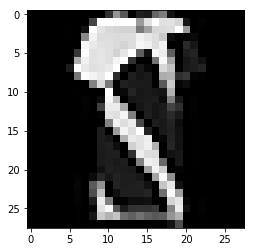

In [3]:
batch = mnist_fashion.train.next_batch(1)
sample_img = batch[0]
sample_img = sample_img.reshape(28, 28)
plt.gray() # use this line if you don't want to see it in color
plt.imshow(sample_img)
plt.show()

## Mapping 28x28 images to 20-dimensional vectors

In [5]:
from functools import partial

input_dim = 28 * 28
size_hidden1 = 500
size_hidden2 = 300
size_hidden3 = 20  # coding layer, reduces the dimsion 
size_hidden4 = size_hidden2
size_hidden5 = size_hidden1
output_dim = input_dim
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, input_dim])
hidden1 = my_dense_layer(X, size_hidden1) # layer 1
hidden2 = my_dense_layer(hidden1, size_hidden2) # Layer 2

hidden3_mean = my_dense_layer(hidden2, size_hidden3, activation=None) 
hidden3_gamma = my_dense_layer(hidden2, size_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32) 
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise # add noise to avoid outputs identical to inputs


hidden4 = my_dense_layer(hidden3, size_hidden4)
hidden5 = my_dense_layer(hidden4, size_hidden5)
logits = my_dense_layer(hidden5, output_dim, activation=None) ## logit values 
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits) ## Cost fucntion as cross entropy 
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # Adam optimizer
training_op = optimizer.minimize(loss) ## minizes dissimilarity between output images and the original images

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [6]:

n_items = 60
n_epochs = 30
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist_fashion.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist_fashion.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_items, size_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 25024.096 	Reconstruction loss: 23203.832 	Latent loss: 1820.2633
1 Train total loss: 25872.596 	Reconstruction loss: 24145.336 	Latent loss: 1727.26
2 Train total loss: 24708.365 	Reconstruction loss: 23038.504 	Latent loss: 1669.8618
3 Train total loss: 23722.408 	Reconstruction loss: 21937.64 	Latent loss: 1784.7681
4 Train total loss: 23843.648 	Reconstruction loss: 22091.008 	Latent loss: 1752.6399
5 Train total loss: 24375.469 	Reconstruction loss: 22703.766 	Latent loss: 1671.7026
6 Train total loss: 25015.494 	Reconstruction loss: 23342.855 	Latent loss: 1672.6384
7 Train total loss: 24271.92 	Reconstruction loss: 22669.47 	Latent loss: 1602.449
8 Train total loss: 24600.746 	Reconstruction loss: 22958.652 	Latent loss: 1642.0933
9 Train total loss: 23235.16 	Reconstruction loss: 21583.107 	Latent loss: 1652.0526
10 Train total loss: 23663.055 	Reconstruction loss: 22027.701 	Latent loss: 1635.3538
11 Train total loss: 23904.23 	Reconstruction loss: 22284.01

## Visualizing the images we generated

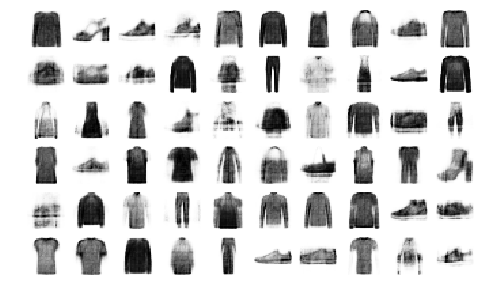

In [7]:
plt.figure(figsize=(8,50)) # not shown in the book
shape = [28,28]
for iteration in range(n_items):
    plt.subplot(n_items, 10, iteration + 1)
    image = outputs_val[iteration]
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Loading teh data with the URL

In [15]:
data_url = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
